<a id='top-page'></a>
# <img src="../images/PCAfold-logo.svg" style="height:100px"> Demo for nonlinear regression

In this tutorial, we present the nonlinear regression utilities from the ``analysis`` module.

## Nonlinear regression

A synthetic data set is created and we perform nonlinear regression using kernel regression:

- [**Generating a synthetic data set**](#data-generation)
- [**Kernel regression**](#kernel-regression)
- [**Nonlinear regression assessment**](#assessment)
    - [**Visual assessment**](#assessment)
    - [**Predicted 2D field for scalar quantities**](#scalar-field)
    - [**Streamplots for predicted vector quantities**](#streamplot)
    - [**Error metrics**](#error)
    - [**Stratified error metrics**](#stratified-error)
    - [**Comparison of two regression solutions**](#comparison)
***

**Should plots be saved?**

In [4]:
save_plots = True

***

We import the necessary modules:

In [2]:
from PCAfold import preprocess
from PCAfold import reduction
from PCAfold import analysis
import numpy as np
%matplotlib inline

and we set some initial parameters:

In [3]:
save_filename = None

<a id='data-generation'></a>
***

## Generating a synthetic data set

[**↑ Go to the top**](#top-page)

We begin by generating a synthetic data set with two independent variables, $x$ and $y$, and one dependent variable, $\phi$, that we will nonlinearly regress using kernel regression.

Generate independent variables $x$ and $y$ from a uniform grid:

In [4]:
n_points = 100
grid = np.linspace(0,100,n_points)
x, y = np.meshgrid(grid, grid)
x = x.flatten()
y = y.flatten()
xy = np.hstack((x[:,None],y[:,None]))
(n_observations, _) = np.shape(xy)

Generate a dependent variable $\phi$ as a quadratic function of $x$:

In [5]:
phi = xy[:,0:1]**2

Visualize the generated data set:

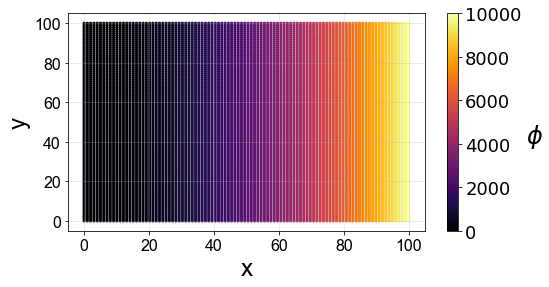

In [6]:
if save_plots: save_filename = '../images/tutorial-regression-data-set.svg'
plt = reduction.plot_2d_manifold(x, 
                                 y, 
                                 color=phi, 
                                 x_label='x', 
                                 y_label='y', 
                                 colorbar_label='$\phi$', 
                                 color_map='inferno', 
                                 figure_size=(8,4), 
                                 save_filename=save_filename)

<a id='kernel-regression'></a>
***

## Kernel regression

[**↑ Go to the top**](#top-page)

We first generate train and test samples using the `DataSampler` class:

In [7]:
train_perc = 80
random_seed = 100

idx = np.zeros((n_observations,)).astype(int)
sample_random = preprocess.DataSampler(idx, random_seed=random_seed, verbose=False)
(idx_train, idx_test) = sample_random.random(train_perc, test_selection_option=1)

xy_train = xy[idx_train,:]
xy_test = xy[idx_test,:]

phi_train = phi[idx_train]
phi_test = phi[idx_test]

Specify the bandwidth for the Nadaraya-Watson kernel:

In [8]:
bandwidth = 10

Fit the kernel regression model with train data:

In [9]:
model = analysis.KReg(xy_train, phi_train)

Predict the test data:

In [10]:
phi_test_predicted = model.predict(xy_test, bandwidth=bandwidth)

Predict all data:

In [11]:
phi_predicted = model.predict(xy, bandwidth=bandwidth)

<a id='assessment'></a>
***

## Nonlinear regression assessment

[**↑ Go to the top**](#top-page)

In this section we will perform few assessments of the quality of the nonlinear regression.

### Visual assessment

We begin by visualizing the regressed (predicted) dependent variable $\phi$. This can be done either in 2D:

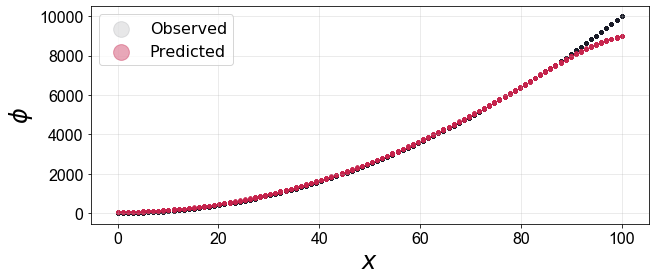

In [12]:
if save_plots: save_filename = '../images/tutorial-regression-result-2d.svg'
plt = analysis.plot_2d_regression(x, 
                                  phi, 
                                  phi_predicted, 
                                  x_label='$x$', 
                                  y_label='$\phi$', 
                                  figure_size=(10,4), 
                                  save_filename=save_filename)

or in 3D:

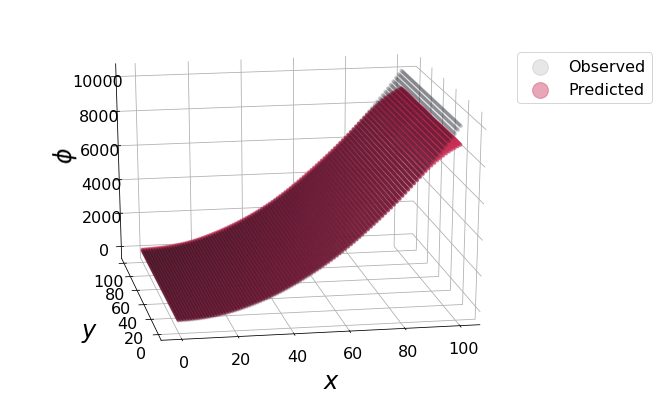

In [13]:
if save_plots: save_filename = '../images/tutorial-regression-result.svg'
plt = analysis.plot_3d_regression(x, 
                                  y, 
                                  phi, 
                                  phi_predicted, 
                                  elev=20, 
                                  azim=-100, 
                                  x_label='$x$', 
                                  y_label='$y$', 
                                  z_label='$\phi$', 
                                  figure_size=(10,7), 
                                  save_filename=save_filename)

<a id='scalar-field'></a>

### Predicted 2D field for scalar quantities

[**↑ Go to the top**](#top-page)

When the predicted variable is a scalar quantity, a scatter plot for the regressed scalar field can be plotted using the function `plot_2d_regression_scalar_field`. Regression of the scalar field can be tested at any user-defined grid, also outside of the bounds of the training data. This can be of particular importance when generating reduced-order models, where the behavior of the regression should be tested outside of the training manifold. 

Below, we show an example on a combustion data set.

In [5]:
X = np.genfromtxt('data-state-space.csv', delimiter=',')
S_X = np.genfromtxt('data-state-space-sources.csv', delimiter=',')

In [6]:
pca_X = reduction.PCA(X, scaling='vast', n_components=2)
PCs = pca_X.transform(X)
PC_sources = pca_X.transform(S_X, nocenter=True)
(PCs_pp, centers_PCs, scales_PCs) = preprocess.center_scale(PCs, '-1to1')

Fit the kernel regression model with the train data:

In [7]:
KReg_model = analysis.KReg(PCs_pp, PC_sources)

We define the regression model function that will make predictions for any query point:

In [21]:
def regression_model(regression_input):
    
    regression_input_CS = (regression_input - centers_PCs)/scales_PCs

    regressed_value = KReg_model.predict(regression_input_CS, bandwidth=0.05)[0,1]
    
    return regressed_value

We first visualize the training manifold, colored by the dependent variable being predicted:

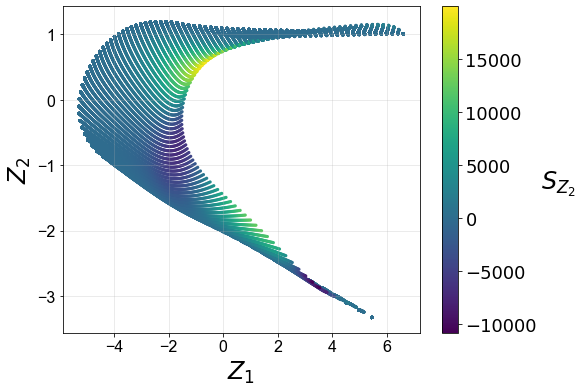

In [22]:
if save_plots: save_filename = '../images/tutorial-regression-scalar-field-training-manifold.png'
reduction.plot_2d_manifold(PCs[:,0], 
                           PCs[:,1], 
                           x_label='$Z_1$',
                           y_label='$Z_2$',
                           color=PC_sources[:,1], 
                           color_map='viridis',
                           colorbar_label='$S_{Z_2}$',
                           figure_size=(8,6),
                           save_filename=save_filename);

Define the bounds for the scalar field:

In [23]:
grid_bounds = ([np.min(PCs[:,0]),np.max(PCs[:,0])],[np.min(PCs[:,1]),np.max(PCs[:,1])])

Plot the regressed scalar field:

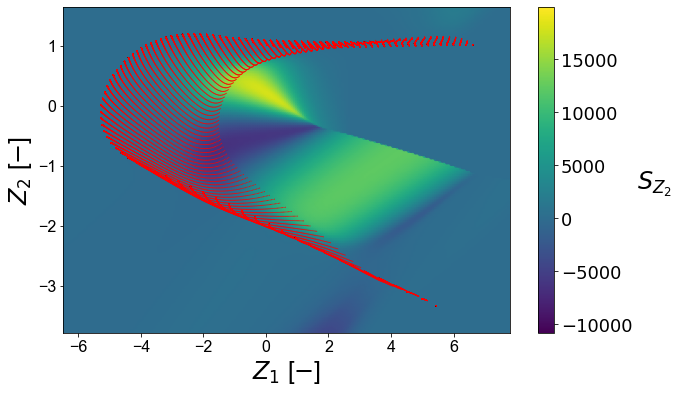

In [24]:
if save_plots: save_filename = '../images/tutorial-regression-scalar-field.png'
plt = analysis.plot_2d_regression_scalar_field(grid_bounds,
                                               regression_model,
                                               x=PCs[:,0],
                                               y=PCs[:,1],
                                               resolution=(200,200),
                                               extension=(10,10),
                                               s_field=10,
                                               s_manifold=1,
                                               x_label='$Z_1$ [$-$]',
                                               y_label='$Z_2$ [$-$]',
                                               manifold_color='r',
                                               colorbar_label='$S_{Z_2}$',
                                               color_map='viridis',
                                               colorbar_range=(np.min(PC_sources[:,1]), np.max(PC_sources[:,1])),
                                               manifold_alpha=1,
                                               grid_on=False,
                                               figure_size=(10,6),
                                               save_filename=save_filename);

<a id='streamplot'></a>

### Streamplots for predicted vector quantities

[**↑ Go to the top**](#top-page)

In a special case, when the predicted variable is a vector, a streamplot of the regressed vector field can be plotted using the function `plot_2d_regression_streamplot`. Regression of a vector field can be tested at any user-defined grid, also outside of the bounds of the training data. This can be of particular importance when generating reduced-order models, where the behavior of the regression should be tested outside of the training manifold. 

Below, we show an example on a synthetic data set:

In [21]:
X = np.random.rand(100,5)
S_X = np.random.rand(100,5)

In [22]:
pca_X = reduction.PCA(X, n_components=2)
PCs = pca_X.transform(X)
S_Z = pca_X.transform(S_X, nocenter=True)

In [23]:
vector_model = analysis.KReg(PCs, S_Z)

We define the regression model function that will make predictions for any query point:

In [24]:
def regression_model(query):

    predicted = vector_model.predict(query, 'nearest_neighbors_isotropic', n_neighbors=1)

    return predicted

Define the bounds for the streamplot:

In [25]:
grid_bounds = ([np.min(PCs[:,0]),np.max(PCs[:,0])],[np.min(PCs[:,1]),np.max(PCs[:,1])])

Plot the regression streamplot:

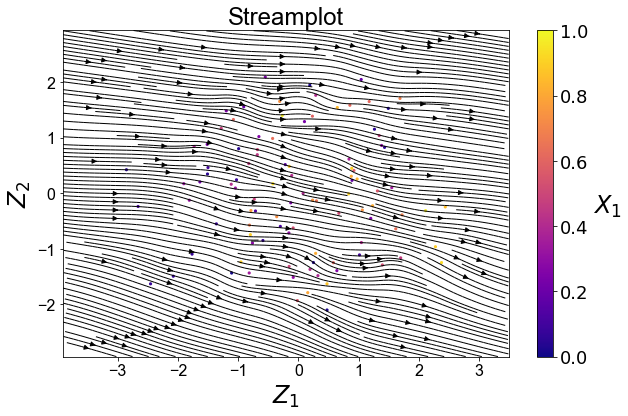

In [26]:
if save_plots: save_filename = '../images/tutorial-regression-streamplot.svg'
plt = analysis.plot_2d_regression_streamplot(grid_bounds,
                                    regression_model,
                                    x=PCs[:,0],
                                    y=PCs[:,1],
                                    resolution=(15,15),
                                    extension=(20,20),
                                    color='k',
                                    x_label='$Z_1$',
                                    y_label='$Z_2$',
                                    manifold_color=X[:,0],
                                    colorbar_label='$X_1$',
                                    color_map='plasma',
                                    colorbar_range=(0,1),
                                    manifold_alpha=1,
                                    grid_on=False,
                                    figure_size=(10,6),
                                    title='Streamplot',
                                    save_filename=save_filename)

<a id='error'></a>

### Error metrics

[**↑ Go to the top**](#top-page)

Several error metrics are available that will measure how well the dependent variable(s) were predicted. Metrics can be accessed individually and collectively. Below, we will show examples of both. The available metrics are:

- Mean absolute error
- Mean squared error
- Root mean squared error
- Normalized root mean squared error
- Turning points
- Good estimate
- Good direction estimate

An example of computing mean absolute error is shown below:

In [27]:
MAE = analysis.mean_absolute_error(phi, phi_predicted)
MAE

98.40068384195676

We also compute the coefficient of determination, $R^2$, values for the test data and entire data: 

In [28]:
r2_test = analysis.coefficient_of_determination(phi_test, phi_test_predicted)
r2_all = analysis.coefficient_of_determination(phi, phi_predicted)

print('All R2:\t\t' + str(round(r2_all, 6)) + '\nTest R2:\t' + str(round(r2_test, 6)))

All R2:		0.995841
Test R2:	0.996152


By instantiating an object of the `RegressionAssessment` class, one can compute all available metrics at once:

In [29]:
regression_metrics = analysis.RegressionAssessment(phi, phi_predicted, variable_names=['$\phi$'], norm='std')

As an example, mean absolute error can be accessed by:

In [30]:
regression_metrics.mean_absolute_error

array([[98.40068384]])

All computed metrics can be printed with the use of the `RegressionAssessment.print_metrics` function. Few output formats are available.

Raw text format:

In [31]:
regression_metrics.print_metrics(table_format=['raw'], float_format='.4f')

-------------------------
$\phi$
R2:	0.9958
MAE:	98.4007
MSE:	37762.8664
RMSE:	194.3267
NRMSE:	0.0645
GDE:	nan


`tex` format:

In [32]:
regression_metrics.print_metrics(table_format=['tex'], float_format='.4f')


\begin{table}[h!]
\begin{center}
\begin{tabular}{ll} \toprule
 & \textit{$\phi$} \\ \midrule
R2 & 0.9958 \\
MAE & 98.4007 \\
MSE & 37762.8664 \\
RMSE & 194.3267 \\
NRMSE & 0.0645 \\
GDE & nan \\
\end{tabular}
\caption{}\label{}
\end{center}
\end{table}



`pandas.DataFrame` format (most recommended for Jupyter notebooks):

In [33]:
regression_metrics.print_metrics(table_format=['pandas'], float_format='.4f')

,R2,MAE,MSE,RMSE,NRMSE,GDE
$\phi$,0.9958,98.4007,"37,762.8664",194.3267,0.0645,nan


Note that with the `float_format` parameter you can change the number of digits displayed:

In [34]:
regression_metrics.print_metrics(table_format=['pandas'], float_format='.2f')

,R2,MAE,MSE,RMSE,NRMSE,GDE
$\phi$,1.00,98.40,"37,762.87",194.33,0.06,nan


<a id='stratified-error'></a>

### Stratified error metrics

[**↑ Go to the top**](#top-page)

In addition to a single value of $R^2$ for the entire data set, we can also compute stratified $R^2$ values. This allows us to observe how kernel regression performed in each strata of the dependent variable $\phi$. We will compute the stratified $R^2$ in 20 bins of $\phi$:

In [35]:
use_global_mean = False
verbose = True

(idx, bins_borders) = preprocess.variable_bins(phi, k=20, verbose=False)

r2_in_bins = analysis.stratified_coefficient_of_determination(phi, phi_predicted, idx=idx, use_global_mean=use_global_mean, verbose=verbose)


Bin	1	| size	 2300	| R2	0.868336
Bin	2	| size	 900	| R2	0.870357
Bin	3	| size	 700	| R2	0.863821
Bin	4	| size	 600	| R2	0.880655
Bin	5	| size	 500	| R2	0.875764
Bin	6	| size	 500	| R2	0.889148
Bin	7	| size	 400	| R2	0.797888
Bin	8	| size	 400	| R2	0.773907
Bin	9	| size	 400	| R2	0.79479
Bin	10	| size	 400	| R2	0.862069
Bin	11	| size	 300	| R2	0.864022
Bin	12	| size	 300	| R2	0.93599
Bin	13	| size	 300	| R2	0.972185
Bin	14	| size	 300	| R2	0.988894
Bin	15	| size	 300	| R2	0.979975
Bin	16	| size	 300	| R2	0.766598
Bin	17	| size	 300	| R2	-0.46525
Bin	18	| size	 200	| R2	-11.158072
Bin	19	| size	 300	| R2	-10.94865
Bin	20	| size	 300	| R2	-28.00655


We can plot the stratified $R^2$ values across bins centers:

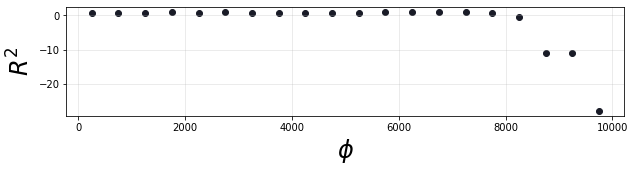

In [36]:
if save_plots: save_filename = '../images/tutorial-regression-stratified-r2.svg'
plt = analysis.plot_stratified_metric(r2_in_bins, 
                                      bins_borders, 
                                      variable_name='$\phi$', 
                                      metric_name='$R^2$', 
                                      yscale='linear',
                                      figure_size=(10,2), 
                                      save_filename=save_filename)

This last plot lets us see that kernel regression performed very well in the
middle range of the dependent variable values but very poorly at both edges of that range.
This is consistent with what we have seen in a 3D plot
that visualized the regression result.


All other regression metrics can also be computed in the data bins, similarly to the example shown for the stratified $R^2$ values.

We will create five bins:

In [37]:
(idx, bins_borders) = preprocess.variable_bins(phi, k=5, verbose=False)

stratified_regression_metrics = analysis.RegressionAssessment(phi, phi_predicted, idx=idx, variable_names=['$\phi$'], norm='std')

All computed stratified metrics can be printed with the use of the `RegressionAssessment.print_stratified_metrics` function. Few output formats are available.

Raw text format:

In [38]:
stratified_regression_metrics.print_stratified_metrics(table_format=['raw'], 
                                                       float_format='.4f')

-------------------------
k1
Observations:	4500
Min:	0.0000
Max:	1975.3086
R2:	0.9920
MAE:	53.2295
MSE:	2890.8754
RMSE:	53.7669
NRMSE:	0.0892
-------------------------
k2
Observations:	1800
Min:	2066.1157
Max:	3922.0488
R2:	0.9906
MAE:	53.8869
MSE:	3032.0995
RMSE:	55.0645
NRMSE:	0.0971
-------------------------
k3
Observations:	1400
Min:	4049.5868
Max:	5893.2762
R2:	0.9912
MAE:	50.4640
MSE:	2865.7682
RMSE:	53.5329
NRMSE:	0.0936
-------------------------
k4
Observations:	1200
Min:	6049.3827
Max:	7901.2346
R2:	0.9956
MAE:	28.4107
MSE:	1492.1498
RMSE:	38.6284
NRMSE:	0.0665
-------------------------
k5
Observations:	1100
Min:	8081.8284
Max:	10000.0000
R2:	0.1271
MAE:	493.3956
MSE:	321235.7188
RMSE:	566.7766
NRMSE:	0.9343


`tex` format:

In [39]:
stratified_regression_metrics.print_stratified_metrics(table_format=['tex'], 
                                                       float_format='.4f')


\begin{table}[h!]
\begin{center}
\begin{tabular}{llllll} \toprule
 & \textit{k1} & \textit{k2} & \textit{k3} & \textit{k4} & \textit{k5} \\ \midrule
Observations & 4500.0000 & 1800.0000 & 1400.0000 & 1200.0000 & 1100.0000 \\
Min & 0.0000 & 2066.1157 & 4049.5868 & 6049.3827 & 8081.8284 \\
Max & 1975.3086 & 3922.0488 & 5893.2762 & 7901.2346 & 10000.0000 \\
R2 & 0.9920 & 0.9906 & 0.9912 & 0.9956 & 0.1271 \\
MAE & 53.2295 & 53.8869 & 50.4640 & 28.4107 & 493.3956 \\
MSE & 2890.8754 & 3032.0995 & 2865.7682 & 1492.1498 & 321235.7188 \\
RMSE & 53.7669 & 55.0645 & 53.5329 & 38.6284 & 566.7766 \\
NRMSE & 0.0892 & 0.0971 & 0.0936 & 0.0665 & 0.9343 \\
\end{tabular}
\caption{}\label{}
\end{center}
\end{table}



`pandas.DataFrame` format (most recommended for Jupyter notebooks):

In [40]:
stratified_regression_metrics.print_stratified_metrics(table_format=['pandas'], 
                                                       float_format='.4f')

,Observations,Min,Max,R2,MAE,MSE,RMSE,NRMSE
k1,4500,0.0000,"1,975.3086",0.9920,53.2295,"2,890.8754",53.7669,0.0892
k2,1800,"2,066.1157","3,922.0488",0.9906,53.8869,"3,032.0995",55.0645,0.0971
k3,1400,"4,049.5868","5,893.2762",0.9912,50.4640,"2,865.7682",53.5329,0.0936
k4,1200,"6,049.3827","7,901.2346",0.9956,28.4107,"1,492.1498",38.6284,0.0665
k5,1100,"8,081.8284","10,000.0000",0.1271,493.3956,"321,235.7188",566.7766,0.9343


<a id='comparison'></a>

### Comparison of two regression solutions

[**↑ Go to the top**](#top-page)

Two object of the `RegressionAssessment` class can be compared when printing the metrics. This results in a color-coded comparison where worse results are colored red and better results are colored green.

Below, we generate a new regression solution that will be compared with the one obtained above. We will increase the bandwidth to get different regression metrics:

In [41]:
phi_predicted_comparison = model.predict(xy, bandwidth=bandwidth+2)

Comparison can be done for the global metrics, where each variable will be compared separately:

In [42]:
regression_metrics_comparison = analysis.RegressionAssessment(phi, phi_predicted_comparison, variable_names=['$\phi$'], norm='std')

In addition, only few user-requested metrics can be selected for printing using the `metrics` input parameter:

In [43]:
regression_metrics.print_metrics(table_format=['pandas'], 
                                 float_format='.4f', 
                                 metrics=['R2', 'NRMSE'], 
                                 comparison=regression_metrics_comparison)

,R2,NRMSE
$\phi$,0.9958,0.0645


and for the stratified metrics, where each bin will be compared separately:

In [44]:
stratified_regression_metrics_comparison = analysis.RegressionAssessment(phi, phi_predicted_comparison, idx=idx)

In [45]:
stratified_regression_metrics.print_stratified_metrics(table_format=['raw'], 
                                                       float_format='.2f', 
                                                       metrics=['R2', 'NRMSE'], 
                                                       comparison=stratified_regression_metrics_comparison)

-------------------------
k1
Observations:	4500
Min:	0.00
Max:	1975.31
R2:	0.99	BETTER
NRMSE:	0.09	BETTER
-------------------------
k2
Observations:	1800
Min:	2066.12
Max:	3922.05
R2:	0.99	BETTER
NRMSE:	0.10	BETTER
-------------------------
k3
Observations:	1400
Min:	4049.59
Max:	5893.28
R2:	0.99	BETTER
NRMSE:	0.09	BETTER
-------------------------
k4
Observations:	1200
Min:	6049.38
Max:	7901.23
R2:	1.00	BETTER
NRMSE:	0.07	BETTER
-------------------------
k5
Observations:	1100
Min:	8081.83
Max:	10000.00
R2:	0.13	BETTER
NRMSE:	0.93	BETTER


***